# Investigation of Nyquist criteria in the context of DEER using a Bayesian approach considering Nyquist for shortest distance in wings of P(r)

This file starts with a low res time trace which barely fulfills Nyquist for the mean distance contained in P(r).
Then a simulation is run that uses a Nyquist frequency thats between the horn and wings of the Pake pattern of the frequency of the shortest distance in P(r) (approx. three detections points per horn oscillation, 1.5 per wing frequency oscillation).
Lastly a simulation is run with a time trace where the Nyquist is too low for either wing or horn frequency of Pake pattern.

## Load packages and setup constants

In [1]:
%load_ext autoreload
%autoreload 2

import pymc3 as pm
import numpy as np
import math as m
import matplotlib.pyplot as plt
import dive 
import deerlab as dl

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Fundamental constants (CODATA 2018)
NA = 6.02214076e23 # Avogadro constant, mol^-1
muB = 9.2740100783e-24 # Bohr magneton, J/T
mu0 = 1.25663706212e-6 # magnetic constant, N A^-2 = T^2 m^3 J^-1
h = 6.62607015e-34 # Planck constant, J/Hz
ge = 2.00231930436256 # free-electron g factor
hbar = h/2/m.pi # reduced Planck constant, J/(rad/s)

w0 = 1e-7*(muB*ge)**2/hbar # rad s^-1

D = (mu0/4/m.pi)*(muB*ge)**2/hbar # dipolar constant, m^3 rad s^-1
D = D/1e6/2/np.pi #--> MHz


# Setup P(r) and determine frequencies for shortest r and mean distance

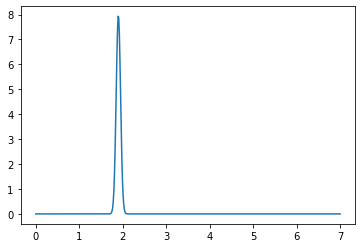

In [3]:
r = np.linspace(0.001,7,500)  

param = [1.9, 0.05]

P = dl.dd_gauss(r,param)

plt.plot(r,P);

In [4]:
idxmin = np.where(P>0.01)[0][0]
idxmean = np.where(P==max(P))[0][0]

rmin = (r[idxmin])
nu_perp = D/(rmin*1e-9)**3
nu_par = 2*nu_perp

print('shortest distance is ' + str(round(rmin,2)) + ' nm')
print('nu_perpendicular = ' + str(round(nu_perp,2)) + ' MHz')
print('nu_parallel = ' + str(round(nu_par,2)) + ' MHz')

rmin = (r[idxmean])
nu_perp = D/(rmin*1e-9)**3
nu_par = 2*nu_perp

print('mean distance is ' + str(round(rmin,2)) + ' nm')
print('nu_perpendicular = ' + str(round(nu_perp,2)) + ' MHz')
print('nu_parallel = ' + str(round(nu_par,2)) + ' MHz')

shortest distance is 1.73 nm
nu_perpendicular = 10.12 MHz
nu_parallel = 20.23 MHz
mean distance is 1.89 nm
nu_perpendicular = 7.65 MHz
nu_parallel = 15.31 MHz


# Experimental parameters (k, λ) and high resolution time trace

In [5]:
lam = 0.5                          # modulation depth
k = 0.01

tmax = 1

In [6]:
t_highres = np.linspace(0,tmax,500)

In [7]:
B_highres = dl.bg_exp(t_highres,k)         # background decay'
K_highres = dl.dipolarkernel(t_highres,r,mod=lam,bg=B_highres)    # kernel matrix

V_highres = K_highres@P + 0*dl.whitegaussnoise(t_highres,0.01,seed=0)  # DEER signal with added noise

# ν<sub>mean,perpendicular</sub> < ν<sub>min,perpendicular</sub> < ν<sub>mean,parallel</sub> < ν<sub>min,parallel</sub> < ν<sub>nyquist</sub>

In [23]:
t = np.linspace(0,tmax,50)

dt = t[2]-t[1]
nu_nyquist = 1/2/dt
r_nyquist = (4 * dt * D)**(1/3)*1e9
nu_min = 2/max(t)

print('Timestep is ' + str(round(dt*1000,2)) + ' ns')
print('Nyquist frequency is ' + str(round(nu_nyquist,2)) + ' MHz')
print('The Nyquist distance is ' + str(round(r_nyquist,2)) + ' nm')
print('Total trace length is ' + str(round(max(t),2)) + ' µs, lowest detectable frequency: ' + str(round(nu_min,2)) + ' MHz')

Timestep is 20.41 ns
Nyquist frequency is 24.5 MHz
The Nyquist distance is 1.62 nm
Total trace length is 1.0 µs, lowest detectable frequency: 2.0 MHz


In [24]:
B = dl.bg_exp(t,k)         # background decay
K = dl.dipolarkernel(t,r,mod=lam,bg=B)    # kernel matrix

Vexp = K@P + 0*dl.whitegaussnoise(t,0.01,seed=0)  # DEER signal with added noise

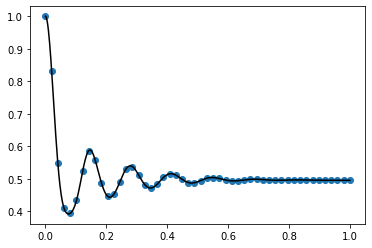

In [28]:
plt.plot(t_highres,V_highres,'k')
plt.scatter(t,Vexp)

In [26]:
pars = {"method": 'regularization', "r": np.linspace(0.5,5,100)}

model = dive.model(t, Vexp, pars)

MCMCparameters = {"draws": 3000,"tune": 1000, "chains": 4, 'cores': 4}
trace = dive.sample(model,MCMCparameters)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>SamplePfromV: [P]
>randTau: [tau]
>randDelta: [delta]
>NUTS: [k, V0, lamb]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 174 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2347 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.18101335347971323, but should be close to 0.8. Try to increase the number of tuning steps.
There were 932 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6004938634300564, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1732 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.34167489550338104, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The es

mean         sd  hdi_3%    hdi_97%  mcse_mean   mcse_sd  ess_bulk  \
k         0.010      0.011   0.000      0.023      0.002     0.002      22.0   
λ         0.515      0.013   0.489      0.542      0.000     0.000     137.0   
V₀        1.026      0.025   0.974      1.077      0.001     0.000     183.0   
σ         0.022      0.013   0.004      0.040      0.005     0.004       8.0   
δ      4831.934  12128.118   0.069  24496.351   1902.427  1354.993       8.0   
lg(α)    -0.863      1.299  -2.655      0.848      0.531     0.396       8.0   

       ess_tail  r_hat  
k         228.0   1.28  
λ         513.0   1.40  
V₀        587.0   1.45  
σ          11.0   1.41  
δ          84.0   1.42  
lg(α)      18.0   1.42

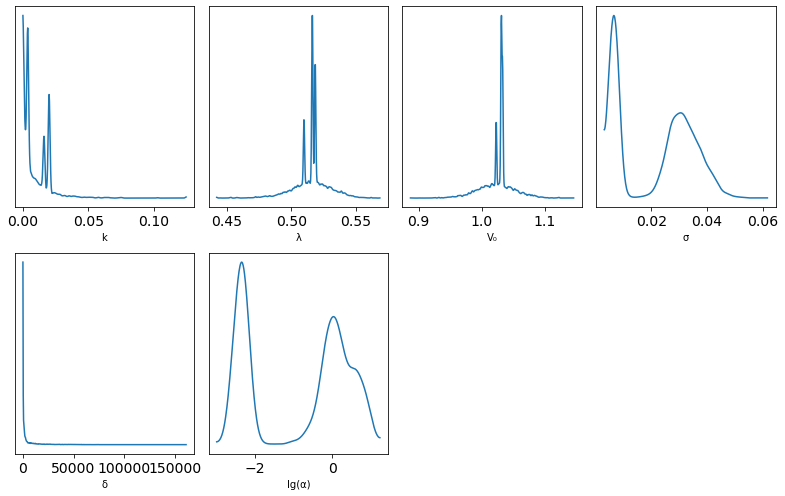

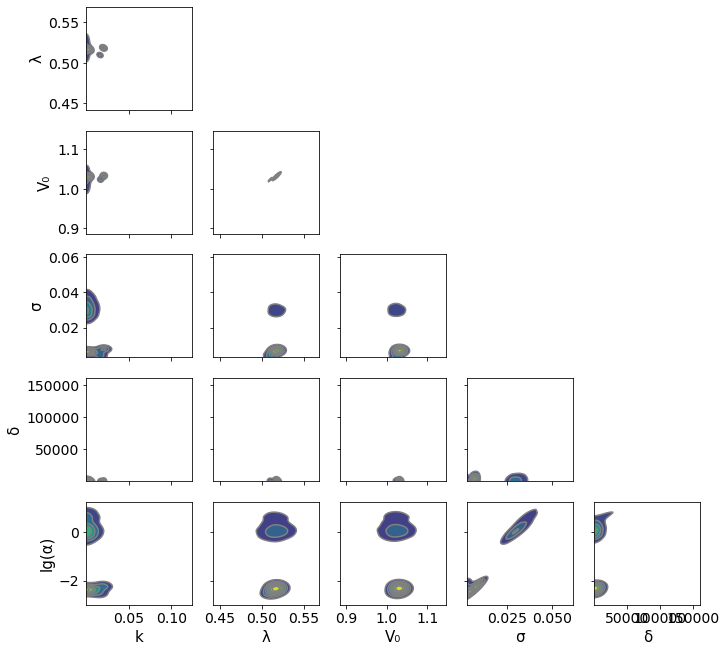

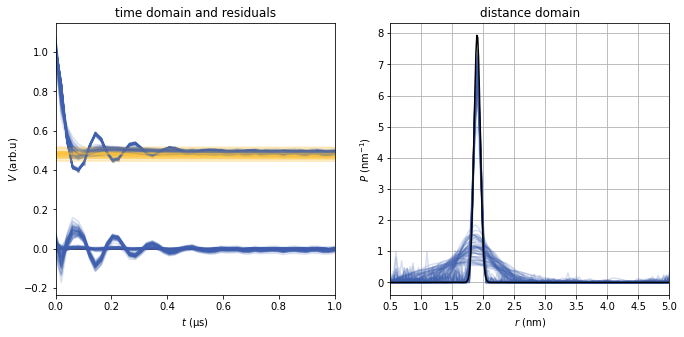

In [27]:
dive.summary(trace, model, Pref = P, rref = r)  

# ν<sub>mean,perpendicular</sub> < ν<sub>min,perpendicular</sub> < ν<sub>nyquist</sub> < ν<sub>mean,parallel</sub> < ν<sub>min,parallel</sub> 

In [29]:
t = np.linspace(0,tmax,25)

dt = t[2]-t[1]
nu_nyquist = 1/2/dt
r_nyquist = (4 * dt * D)**(1/3)*1e9
nu_min = 2/max(t)

print('Timestep is ' + str(round(dt*1000,2)) + ' ns')
print('Nyquist frequency is ' + str(round(nu_nyquist,2)) + ' MHz')
print('The Nyquist distance is ' + str(round(r_nyquist,2)) + ' nm')
print('Total trace length is ' + str(round(max(t),2)) + ' µs, lowest detectable frequency: ' + str(round(nu_min,2)) + ' MHz')

Timestep is 41.67 ns
Nyquist frequency is 12.0 MHz
The Nyquist distance is 2.05 nm
Total trace length is 1.0 µs, lowest detectable frequency: 2.0 MHz


In [30]:
B = dl.bg_exp(t,k)         # background decay
K = dl.dipolarkernel(t,r,mod=lam,bg=B)    # kernel matrix

Vexp = K@P + 0*dl.whitegaussnoise(t,0.01,seed=0)  # DEER signal with added noise

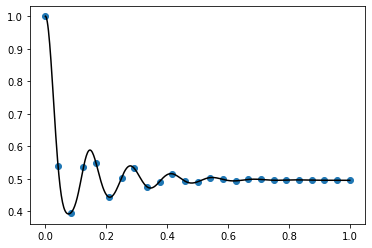

In [31]:
plt.plot(t_highres,V_highres,'k')
plt.scatter(t,Vexp)

In [16]:
pars = {"method": 'regularization', "r": np.linspace(0.5,5,100)}

model = dive.model(t, Vexp, pars)

pars = {"method": 'regularization', "r": np.linspace(0.5,5,100)}

MCMCparameters = {"draws": 3000,"tune": 1000, "chains": 4, 'cores': 4}
trace = dive.sample(model,MCMCparameters)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>SamplePfromV: [P]
>randTau: [tau]
>randDelta: [delta]
>NUTS: [k, V0, lamb]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 301 seconds.
There were 108 divergences after tuning. Increase `target_accept` or reparameterize.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


mean         sd    hdi_3%    hdi_97%  mcse_mean  mcse_sd  \
k          0.013      0.017     0.000      0.045      0.000    0.000   
λ          0.499      0.019     0.465      0.534      0.000    0.000   
V₀         0.992      0.033     0.928      1.052      0.001    0.001   
σ          0.031      0.005     0.022      0.041      0.000    0.000   
δ      26818.790  21243.837  1965.798  62467.653   1274.114  901.882   
lg(α)      0.648      0.186     0.297      0.999      0.011    0.008   

       ess_bulk  ess_tail  r_hat  
k        2682.0    2872.0   1.00  
λ        1957.0    2063.0   1.00  
V₀       2012.0    2188.0   1.00  
σ        3882.0    6056.0   1.00  
δ         239.0     555.0   1.01  
lg(α)     275.0     685.0   1.01

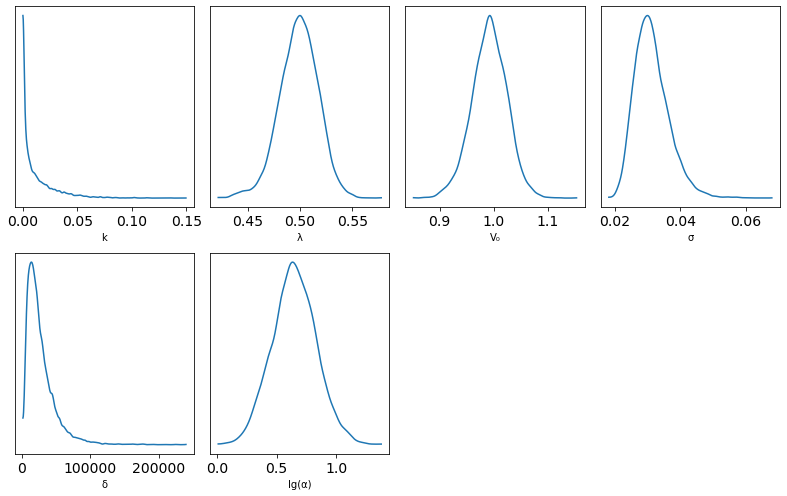

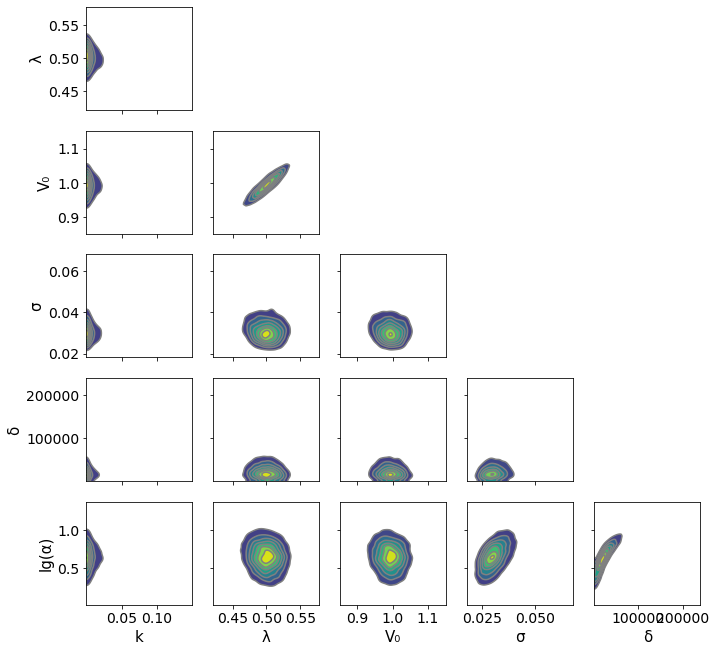

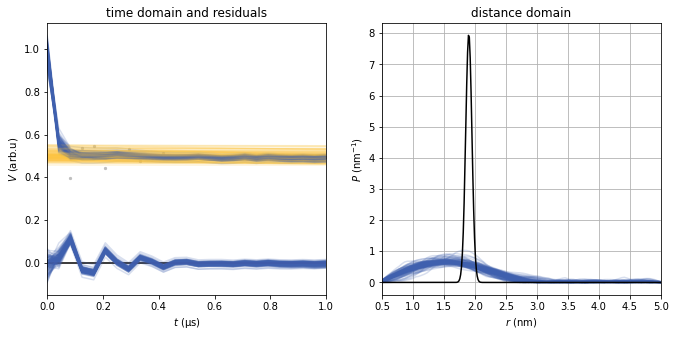

In [17]:
dive.summary(trace, model, Pref = P, rref = r)  

# ν<sub>nyquist</sub> < ν<sub>mean,perpendicular</sub> < ν<sub>min,perpendicular</sub> <  ν<sub>mean,parallel</sub> < ν<sub>min,parallel</sub> 

In [18]:
t = np.linspace(0,tmax,14)

dt = t[2]-t[1]
nu_nyquist = 1/2/dt
r_nyquist = (4 * dt * D)**(1/3)*1e9
nu_min = 2/max(t)

print('Timestep is ' + str(round(dt*1000,2)) + ' ns')
print('Nyquist frequency is ' + str(round(nu_nyquist,2)) + ' MHz')
print('The Nyquist distance is ' + str(round(r_nyquist,2)) + ' nm')
print('Total trace length is ' + str(round(max(t),2)) + ' µs, lowest detectable frequency: ' + str(round(nu_min,2)) + ' MHz')

Timestep is 76.92 ns
Nyquist frequency is 6.5 MHz
The Nyquist distance is 2.52 nm
Total trace length is 1.0 µs, lowest detectable frequency: 2.0 MHz


In [19]:
B = dl.bg_exp(t,k)         # background decay
K = dl.dipolarkernel(t,r,mod=lam,bg=B)    # kernel matrix

Vexp = K@P + 0*dl.whitegaussnoise(t,0.01,seed=0)  # DEER signal with added noise

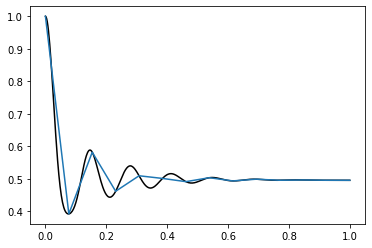

In [20]:
plt.plot(t_highres,V_highres,'k')
plt.scatter(t,Vexp);

In [21]:
pars = {"method": 'regularization', "r": np.linspace(0.5,5,100)}

model = dive.model(t, Vexp, pars)

MCMCparameters = {"draws": 3000,"tune": 1000, "chains": 4, 'cores': 4}
trace = dive.sample(model,MCMCparameters)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>SamplePfromV: [P]
>randTau: [tau]
>randDelta: [delta]
>NUTS: [k, V0, lamb]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 317 seconds.
There were 192 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 264 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5843396329896515, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


mean         sd   hdi_3%     hdi_97%  mcse_mean   mcse_sd  \
k          0.032      0.042    0.000       0.109      0.001     0.001   
λ          0.488      0.038    0.415       0.555      0.001     0.001   
V₀         0.977      0.056    0.862       1.075      0.002     0.001   
σ          0.052      0.015    0.030       0.082      0.001     0.001   
δ      67277.656  92141.243  837.880  212207.207   7146.954  5062.554   
lg(α)      0.988      0.310    0.390       1.558      0.030     0.022   

       ess_bulk  ess_tail  r_hat  
k        1255.0     930.0   1.00  
λ         868.0     902.0   1.01  
V₀        853.0    1044.0   1.01  
σ         351.0    1241.0   1.02  
δ          96.0     358.0   1.05  
lg(α)     103.0     401.0   1.05

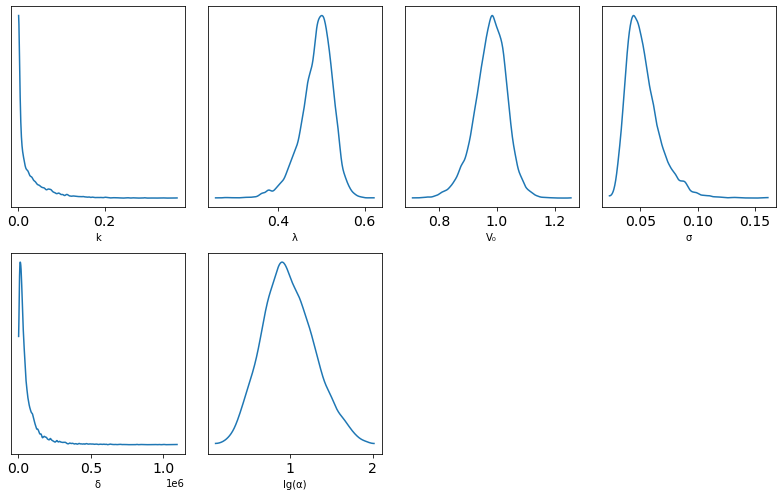

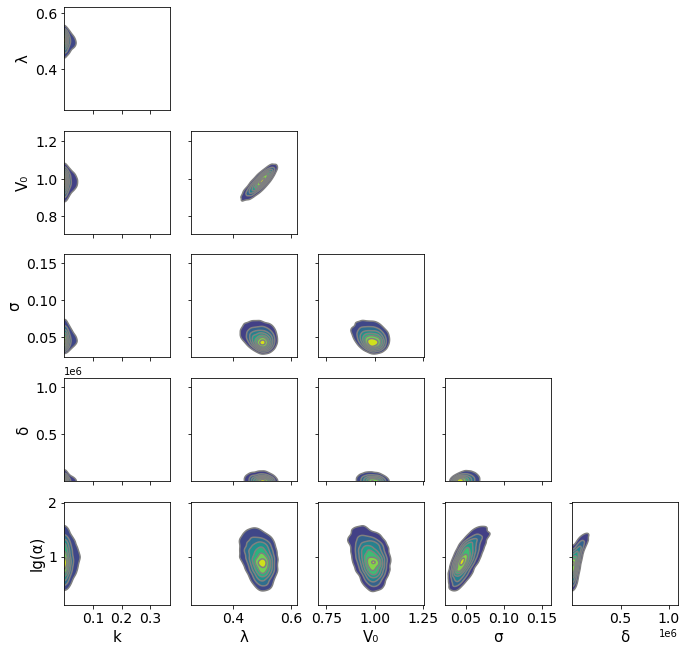

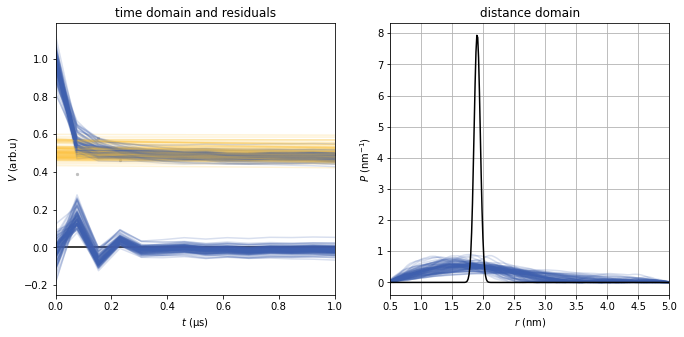

In [22]:
dive.summary(trace, model, Pref = P, rref = r)  